# Download data

In [1]:
# !curl -O https://store.pangaea.de/Publications/ReiserF-etal_2020/Antarctic_Relleads_2003_2019.nc

# Install software

In [2]:
# %pip install xoak

In [3]:
# %pip install pybresenham

# Global parameters

In [4]:
# parameters

# Skipping grid points. Set to None for the full grid.
subsample_i = 2
subsample_j = 2

# Read and standardize data

(We'll make sure dimension names make sense, dimensional coords are present, etc.)

In [5]:
import xarray as xr
import numpy as np

In [6]:
ds = xr.open_dataset("Antarctic_Relleads_2003_2019.nc")
ds

<xarray.Dataset>
Dimensions:        (lat: 8300, lon: 7900)
Dimensions without coordinates: lat, lon
Data variables:
    Latitude       (lat, lon) float64 ...
    Longitude      (lat, lon) float64 ...
    LeadFrequency  (lat, lon) uint8 ...
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

In [7]:
ds = ds.isel(
    lon=slice(None, None, subsample_i), 
    lat=slice(None, None, subsample_j), 
)

In [8]:
ds = ds.rename({"lon": "i", "lat": "j"})

ds = ds.set_coords(["Latitude", "Longitude"])

ds = ds.assign_coords(
    i=np.arange(ds.dims["i"]),
    j=np.arange(ds.dims["j"]),
)

ds = ds.where(ds.LeadFrequency < 200)

In [9]:
ds

<xarray.Dataset>
Dimensions:        (j: 4150, i: 3950)
Coordinates:
    Latitude       (j, i) float64 -39.24 -39.25 -39.26 ... -41.49 -41.47 -41.46
    Longitude      (j, i) float64 -42.24 -42.23 -42.21 ... 135.0 135.0 135.0
  * i              (i) int64 0 1 2 3 4 5 6 ... 3944 3945 3946 3947 3948 3949
  * j              (j) int64 0 1 2 3 4 5 6 ... 4144 4145 4146 4147 4148 4149
Data variables:
    LeadFrequency  (j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

# Use Xoak for selecting a section

(The index constructed by Xoak can be large.  On my laptop, using the full grid crashes.)

In [10]:
import xoak

In [11]:
ds.xoak.set_index(['Latitude', 'Longitude'], 'sklearn_geo_balltree')

Select a single point just for making sure things are working:

In [12]:
ds.xoak.sel(
    Latitude=xr.DataArray(-70),
    Longitude=xr.DataArray(12.3),
)

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    Latitude       float64 -70.0
    Longitude      float64 12.31
    i              int64 2208
    j              int64 1106
Data variables:
    LeadFrequency  float64 5.0
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

Selecting a section of 1000 points (start and end didn't get much thought...)

In [13]:
section = xr.Dataset(
    {
        "Longitude": (("s", ), 12.3 * np.ones(shape=(1_000, ))),
        "Latitude": (("s", ), np.linspace(-89, -60, 1_000)),
    }
)
section

<xarray.Dataset>
Dimensions:    (s: 1000)
Dimensions without coordinates: s
Data variables:
    Longitude  (s) float64 12.3 12.3 12.3 12.3 12.3 ... 12.3 12.3 12.3 12.3 12.3
    Latitude   (s) float64 -89.0 -88.97 -88.94 -88.91 ... -60.06 -60.03 -60.0

In [14]:
ds_selected = ds.xoak.sel(
    Longitude=section.Longitude,
    Latitude=section.Latitude,
)

In [15]:
ds_selected

<xarray.Dataset>
Dimensions:        (s: 1000)
Coordinates:
    Latitude       (s) float64 -89.01 -88.97 -88.95 ... -60.05 -60.03 -60.0
    Longitude      (s) float64 11.95 12.53 12.31 11.89 ... 12.29 12.29 12.3
    i              (s) int64 1986 1987 1987 1987 1988 ... 2328 2328 2328 2329
    j              (s) int64 2122 2120 2119 2117 2116 ... 558 556 554 553 551
Dimensions without coordinates: s
Data variables:
    LeadFrequency  (s) float64 nan nan nan nan nan nan ... 9.0 7.0 9.0 10.0 9.0
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

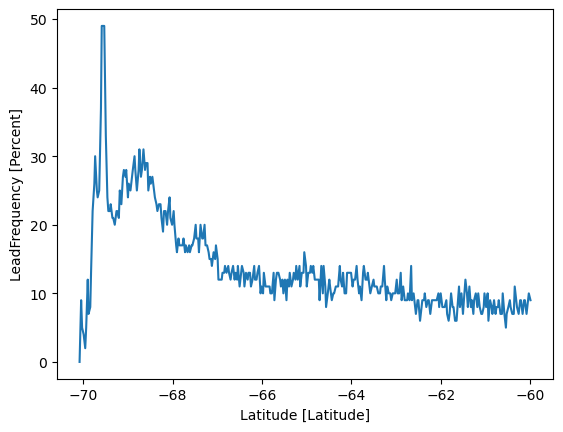

In [16]:
ds_selected.LeadFrequency.plot(x="Latitude")

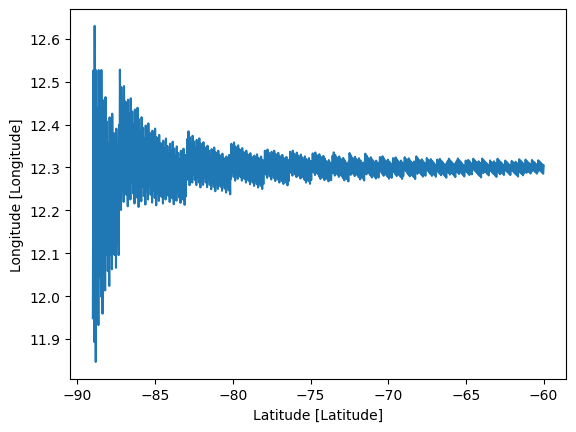

In [17]:
ds_selected.Longitude.plot(x="Latitude")

# Construct a dense and "straight" line in projected space

See https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm

In [18]:
import pybresenham

In [19]:
section_nodes = xr.Dataset(
    {
        "Longitude": (("n", ), [12.3, 12.3]),
        "Latitude": (("n", ), [-89, -60]),
    }
)
section_nodes

<xarray.Dataset>
Dimensions:    (n: 2)
Dimensions without coordinates: n
Data variables:
    Longitude  (n) float64 12.3 12.3
    Latitude   (n) int64 -89 -60

Find start and end _indices_.

In [20]:
ds_selected_nodes = ds.xoak.sel(
    Longitude=section_nodes.Longitude,
    Latitude=section_nodes.Latitude,
)

ds_selected_nodes

<xarray.Dataset>
Dimensions:        (n: 2)
Coordinates:
    Latitude       (n) float64 -89.01 -60.0
    Longitude      (n) float64 11.95 12.3
    i              (n) int64 1986 2329
    j              (n) int64 2122 551
Dimensions without coordinates: n
Data variables:
    LeadFrequency  (n) float64 nan 9.0
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

Construct pixelated line:

In [21]:
i, j = zip(*pybresenham.line(
    ds_selected_nodes.i[0].astype(float).data[()],
    ds_selected_nodes.j[0].astype(float).data[()],
    ds_selected_nodes.i[1].astype(float).data[()],
    ds_selected_nodes.j[1].astype(float).data[()],
))

In [22]:
ds_selected_nodes_between = ds.sel(
    i=xr.DataArray(list(i), dims=("s", )).astype(float),
    j=xr.DataArray(list(j), dims=("s", )).astype(float),
)

In [23]:
ds_selected_nodes_between

<xarray.Dataset>
Dimensions:        (s: 1572)
Coordinates:
    Latitude       (s) float64 -89.01 -88.99 -88.97 ... -60.03 -60.01 -60.0
    Longitude      (s) float64 11.95 11.73 11.52 12.31 ... 12.32 12.31 12.3
    i              (s) int64 1986 1986 1986 1987 1987 ... 2328 2329 2329 2329
    j              (s) int64 2122 2121 2120 2119 2118 ... 555 554 553 552 551
Dimensions without coordinates: s
Data variables:
    LeadFrequency  (s) float64 nan nan nan nan nan nan ... 9.0 9.0 8.0 8.0 9.0
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

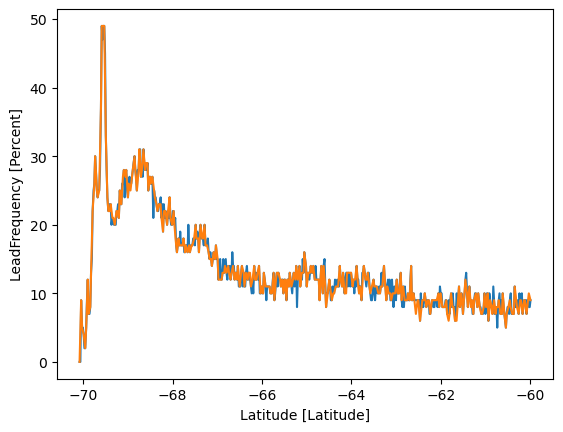

In [24]:
ds_selected_nodes_between.LeadFrequency.plot(x="Latitude")
ds_selected.LeadFrequency.plot(x="Latitude")

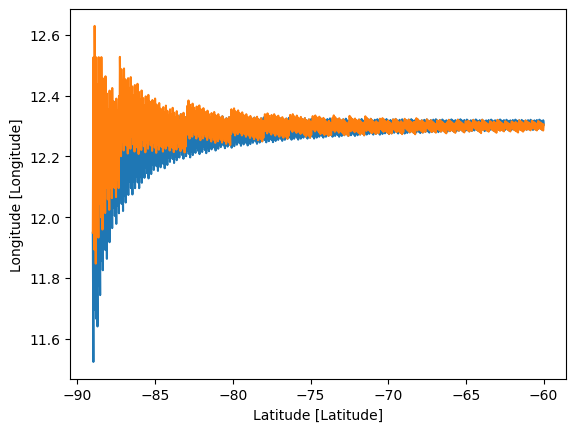

In [25]:
ds_selected_nodes_between.Longitude.plot(x="Latitude")
ds_selected.Longitude.plot(x="Latitude")

# Multi-segment section

In [26]:
section_nodes = xr.Dataset(
    {
        "Longitude": (("n", ), [0.5, 0.5, 20, 20.3, 167.0, 168.3, 270.5, 355.1]),
        "Latitude": (("n", ), [-89, -50, -50, -80, -80.2, -70, -65, -85]),
    }
)
section_nodes

<xarray.Dataset>
Dimensions:    (n: 8)
Dimensions without coordinates: n
Data variables:
    Longitude  (n) float64 0.5 0.5 20.0 20.3 167.0 168.3 270.5 355.1
    Latitude   (n) float64 -89.0 -50.0 -50.0 -80.0 -80.2 -70.0 -65.0 -85.0

Find start and end _indices_.

In [27]:
ds_selected_nodes = ds.xoak.sel(
    Longitude=section_nodes.Longitude,
    Latitude=section_nodes.Latitude,
)

ds_selected_nodes

<xarray.Dataset>
Dimensions:        (n: 8)
Coordinates:
    Latitude       (n) float64 -88.99 -51.33 -50.0 -79.99 ... -70.0 -65.0 -85.01
    Longitude      (n) float64 0.1463 0.5306 19.99 20.26 ... 168.3 -89.51 -4.846
    i              (n) int64 1975 1995 2746 2163 2095 2197 600 1952
    j              (n) int64 2120 0 55 1665 2693 3246 2163 1905
Dimensions without coordinates: n
Data variables:
    LeadFrequency  (n) float64 nan 0.0 0.0 nan nan 14.0 15.0 nan
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

Construct pixelated line:

In [28]:
i, j = list(zip(*pybresenham.lines(
    list(zip(ds_selected_nodes.i.astype(float).data, ds_selected_nodes.j.astype(float).data))
)))

i[:10], j[:10]

((1975.0, 1975, 1975, 1975, 1975, 1975, 1975, 1975, 1975, 1975),
 (2120.0, 2119, 2118, 2117, 2116, 2115, 2114, 2113, 2112, 2111))

In [29]:
ds_selected_nodes_between = ds.sel(
    i=xr.DataArray(list(i), dims=("s", )).astype(float),
    j=xr.DataArray(list(j), dims=("s", )).astype(float),
)

In [30]:
ds_selected_nodes_between

<xarray.Dataset>
Dimensions:        (s: 9012)
Coordinates:
    Latitude       (s) float64 -88.99 -88.97 -88.95 ... -85.0 -85.01 -85.01
    Longitude      (s) float64 0.1463 0.1437 0.1411 ... -5.268 -5.057 -4.846
    i              (s) int64 1975 1975 1975 1975 1975 ... 1949 1950 1951 1952
    j              (s) int64 2120 2119 2118 2117 2116 ... 1906 1905 1905 1905
Dimensions without coordinates: s
Data variables:
    LeadFrequency  (s) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:   Average Lead-Frequency for the Antarctic for winter months...
    Institutaion:  University of Trier, Department of Environmental Meteorology
    Author:        Fabian Reiser, Sascha Willmes, Günther Heinemann
    References:    F. Reiser, S. Willmes, G. Heinemann (2020):               ...
    Title:         relative lead frequencies for the Antarctic, 2003 - 2019, ...
    Version:       1.0
    Projection:    Data projected to NSIDC Sea Ice Polar Stereographic South....
    EPSG:          3412
    proj4string:   +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y...

In [31]:
from matplotlib import pyplot as plt
import cartopy

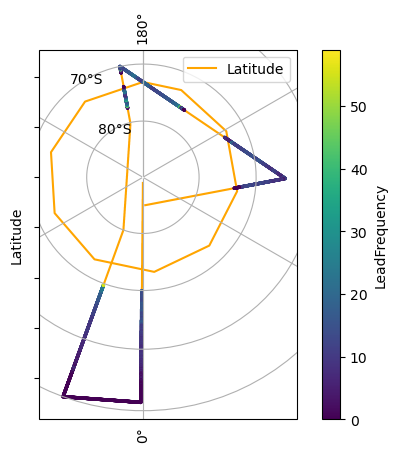

In [32]:
fig, ax = plt.subplots(
    1, 1, 
    subplot_kw={
        "projection": cartopy.crs.Stereographic(central_latitude=-90, central_longitude=180)
    },
)

ds_selected_nodes_between.to_pandas().plot.line(
    x="Longitude", y="Latitude", c="orange",
    ax=ax, transform=cartopy.crs.PlateCarree(),
    zorder=-100,
)

ds_selected_nodes_between.to_pandas().plot.scatter(
    x="Longitude", y="Latitude", s=2, c="LeadFrequency",
    ax=ax, transform=cartopy.crs.PlateCarree()
)

ax.set_xticklabels([])
ax.set_yticklabels([])


ax.gridlines(draw_labels=True)